# Albrecht

In [1]:
dataset = "albrecht_pre"

time: 2 ms


## Rohe Daten
Baue Datenbankverbindung auf und zeige 3 Beispieldaten aus dem vorbereiteten Datensatz "Desharnais".

In [2]:
from libs.data.Db import Db
import pandas as pd

db = Db().getDb()
desh = db[dataset]

data = pd.DataFrame(
    list(desh.find({}, { 'id': 0, '_id': 0 }))
)

list(desh.find().limit(3))

[{'_id': ObjectId('5cae65b01b21430025242c04'),
  'Effort': 105.2,
  'AdjFP': 2.625750687924765,
  'FPAdj': 0.07875236506747665,
  'File': 1.2256975989286996,
  'Input': 4.227015879700005,
  'Inquiry': 2.806335291372736,
  'Output': 1.4740492063095894,
  'RawFPcounts': 2.851263933397239},
 {'_id': ObjectId('5cae65b01b21430025242c05'),
  'Effort': 102.4,
  'AdjFP': 2.3075730260895373,
  'FPAdj': 0.07875236506747665,
  'File': 2.805120008286487,
  'Input': -0.4220097686770872,
  'Inquiry': 3.070460965854876,
  'Output': 2.9844050433164595,
  'RawFPcounts': 2.508243992163322},
 {'_id': ObjectId('5cae65b01b21430025242c06'),
  'Effort': 11.1,
  'AdjFP': -0.45973532224053937,
  'FPAdj': -1.4332930442280802,
  'File': -0.3537248104290878,
  'Input': 0.8232649585667767,
  'Inquiry': -0.8914241513772221,
  'Output': -0.5881674172959446,
  'RawFPcounts': -0.2336588275683174}]

time: 511 ms


### Data

In [3]:
import pandas as pd

X_data = pd.DataFrame(
    list(desh.find({}, { 'Effort': 0, 'id': 0, '_id': 0 }))
)
y_data = pd.DataFrame(
    list(desh.find({}, { 'Effort': 1, '_id': 0 }))
)
header = list(X_data.columns.values)

time: 9.6 ms


Funktion zum Berechnen der Baumtiefe

In [4]:
def dectree_max_depth(tree):
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

time: 20 ms


# Multirun

In [5]:
from sklearn.model_selection import train_test_split
from libs.evaluation.Metrics import Metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from libs.tree.ModelTree import ModelTree
from sklearn.ensemble import RandomForestRegressor
from libs.forest.RandomForestModelTree import RandomForestModelTree
from sklearn.metrics import make_scorer
from datetime import datetime
import pandas as pd
import numpy as np
import os
import time

def my_scorer(y_true, y_pred):
    return Metrics().pred(y_true, y_pred)

X = X_data.values
y = np.ravel(y_data.values.astype('float')) # scikit needs to know what kind of problem to solve

n_runs = 30
m_dt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_mt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_rfdt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_rfmt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
for i in range(n_runs):
    print("{}/{}".format(i+1, n_runs))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    searchSpace_trees = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
        "min_samples_split": [0.05, 0.1, 0.15, 0.2, 0.3],
        "min_samples_leaf": [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        "max_features": range(1, len(header)+1),
        "criterion": ["mse", "mae"],
        "max_leaf_nodes": [2, 5, 10, 15, 20, None] # 2 provocates a max_depth of 1, which wouldn't be tested due to a bug, see: https://github.com/scikit-learn/scikit-learn/issues/13149
        # do not test splitter here, see: https://stackoverflow.com/a/46759065
    }
    
    searchSpace_forests = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18, 20, None], 
        "min_samples_split": [0.05, 0.1, 0.15, 0.2, 0.3],
        "min_samples_leaf": [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        "max_features": range(1, len(header)+1),
        "criterion": ["mse", "mae"],
        "max_leaf_nodes": [2, 5, 10, 15, 20, None], # 2 provocates a max_depth of 1, which wouldn't be tested due to a bug, see: https://github.com/scikit-learn/scikit-learn/issues/13149
        "bootstrap": [True, False],
        #"oob_score": [True],
        "n_estimators": [20],
        "n_jobs": [-1]
    }
    
    #--------------------------
    print("DT")
    start_time = time.clock()
    
    rs_dt = RandomizedSearchCV(DecisionTreeRegressor(), searchSpace_trees, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False)
    rs_dt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_dt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        dt = DecisionTreeRegressor(
            criterion = rs_dt.best_params_["criterion"],
            max_depth = rs_dt.best_params_["max_depth"],
            min_samples_split = rs_dt.best_params_["min_samples_split"],
            min_samples_leaf = rs_dt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_dt.best_params_["max_leaf_nodes"],
            max_features = rs_dt.best_params_["max_features"]
        )
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])
        print("Tree-depth: {}".format(dectree_max_depth(dt.tree_)))

    m_dt['mmre'].append(np.mean(mmres))
    m_dt['mdmre'].append(np.mean(mdmres))
    m_dt['pred'].append(np.mean(preds))
    m_dt['mmer'].append(np.mean(mmers))
    m_dt['mdmer'].append(np.mean(mdmers))
    m_dt['mae'].append(np.mean(maes))
    m_dt['mbre'].append(np.mean(mbres))
    m_dt['mibre'].append(np.mean(mibres))
    m_dt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("MT")
    start_time = time.clock()
    
    rs_mt = RandomizedSearchCV(ModelTree(), searchSpace_trees, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False)
    rs_mt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_mt.best_params_))
    
    mmres_mt = []
    mdmres_mt = []
    preds_mt = []
    mmers_mt = []
    mdmers_mt = []
    maes_mt = []
    mbres_mt = []
    mibres_mt = []
    sas_mt = []
    for i in range(1):
        mt = ModelTree(
            criterion = rs_mt.best_params_["criterion"],
            max_depth = rs_mt.best_params_["max_depth"],
            min_samples_split = rs_mt.best_params_["min_samples_split"],
            min_samples_leaf = rs_mt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_mt.best_params_["max_leaf_nodes"],
            max_features = rs_mt.best_params_["max_features"]
        )
        mt.fit(X_train, y_train)
        y_pred = mt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres_mt.append(metrics['mmre'])
        mdmres_mt.append(metrics['mdmre'])
        preds_mt.append(metrics['pred'])
        mmers_mt.append(metrics['mmer'])
        mdmers_mt.append(metrics['mdmer'])
        maes_mt.append(metrics['mae'])
        mbres_mt.append(metrics['mbre'])
        mibres_mt.append(metrics['mibre'])
        sas_mt.append(metrics['sa'])
        print("Tree-depth: {}".format(dectree_max_depth(mt.tree_)))

    m_mt['mmre'].append(np.mean(mmres_mt))
    m_mt['mdmre'].append(np.mean(mdmres_mt))
    m_mt['pred'].append(np.mean(preds_mt))
    m_mt['mmer'].append(np.mean(mmers_mt))
    m_mt['mdmer'].append(np.mean(mdmers_mt))
    m_mt['mae'].append(np.mean(maes_mt))
    m_mt['mbre'].append(np.mean(mbres_mt))
    m_mt['mibre'].append(np.mean(mibres_mt))
    m_mt['sa'].append(np.mean(sas_mt))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("RFDT")
    start_time = time.clock()
    
    rs_rfdt = RandomizedSearchCV(RandomForestRegressor(), searchSpace_forests, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False, error_score=0.0)
    rs_rfdt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_rfdt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        rfdt = RandomForestRegressor(
            criterion = rs_rfdt.best_params_["criterion"],
            max_depth = rs_rfdt.best_params_["max_depth"],
            min_samples_split = rs_rfdt.best_params_["min_samples_split"],
            min_samples_leaf = rs_rfdt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_rfdt.best_params_["max_leaf_nodes"],
            max_features = rs_rfdt.best_params_["max_features"],
            bootstrap = rs_rfdt.best_params_["bootstrap"],
            n_estimators = 1000
        )
        rfdt.fit(X_train, y_train)
        y_pred = rfdt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])

    m_rfdt['mmre'].append(np.mean(mmres))
    m_rfdt['mdmre'].append(np.mean(mdmres))
    m_rfdt['pred'].append(np.mean(preds))
    m_rfdt['mmer'].append(np.mean(mmers))
    m_rfdt['mdmer'].append(np.mean(mdmers))
    m_rfdt['mae'].append(np.mean(maes))
    m_rfdt['mbre'].append(np.mean(mbres))
    m_rfdt['mibre'].append(np.mean(mibres))
    m_rfdt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("RFMT")
    start_time = time.clock()
    
    rs_rfmt = RandomizedSearchCV(RandomForestModelTree(), searchSpace_forests, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False, error_score=0.0)
    rs_rfmt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_rfmt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        rfmt = RandomForestModelTree(
            criterion = rs_rfmt.best_params_["criterion"],
            max_depth = rs_rfmt.best_params_["max_depth"],
            min_samples_split = rs_rfmt.best_params_["min_samples_split"],
            min_samples_leaf = rs_rfmt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_rfmt.best_params_["max_leaf_nodes"],
            max_features = rs_rfmt.best_params_["max_features"],
            bootstrap = rs_rfmt.best_params_["bootstrap"],
            n_estimators = 1000
        )
        rfmt.fit(X_train, y_train)
        y_pred = rfmt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])

    m_rfmt['mmre'].append(np.mean(mmres))
    m_rfmt['mdmre'].append(np.mean(mdmres))
    m_rfmt['pred'].append(np.mean(preds))
    m_rfmt['mmer'].append(np.mean(mmers))
    m_rfmt['mdmer'].append(np.mean(mdmers))
    m_rfmt['mae'].append(np.mean(maes))
    m_rfmt['mbre'].append(np.mean(mbres))
    m_rfmt['mibre'].append(np.mean(mibres))
    m_rfmt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))

print("DT:")
print("MMRE: {}\n{}".format(np.mean(m_dt['mmre']), m_dt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_dt['mdmre']), m_dt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_dt['pred']), m_dt['pred']))
print("MMER: {}\n{}".format(np.mean(m_dt['mmer']), m_dt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_dt['mdmer']), m_dt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_dt['mae']), m_dt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_dt['mbre']), m_dt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_dt['mibre']), m_dt['mibre']))
print("SA: {}\n{}".format(np.mean(m_dt['sa']), m_dt['sa']))
print("------------------------------------------------")
print("MT:")
print("MMRE: {}\n{}".format(np.mean(m_mt['mmre']), m_mt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_mt['mdmre']), m_mt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_mt['pred']), m_mt['pred']))
print("MMER: {}\n{}".format(np.mean(m_mt['mmer']), m_mt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_mt['mdmer']), m_mt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_mt['mae']), m_mt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_mt['mbre']), m_mt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_mt['mibre']), m_mt['mibre']))
print("SA: {}\n{}".format(np.mean(m_mt['sa']), m_mt['sa']))
print("------------------------------------------------")
print("RFDT:")
print("MMRE: {}\n{}".format(np.mean(m_rfdt['mmre']), m_rfdt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_rfdt['mdmre']), m_rfdt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_rfdt['pred']), m_rfdt['pred']))
print("MMER: {}\n{}".format(np.mean(m_rfdt['mmer']), m_rfdt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_rfdt['mdmer']), m_rfdt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_rfdt['mae']), m_rfdt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_rfdt['mbre']), m_rfdt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_rfdt['mibre']), m_rfdt['mibre']))
print("SA: {}\n{}".format(np.mean(m_rfdt['sa']), m_rfdt['sa']))
print("------------------------------------------------")
print("RFMT:")
print("MMRE: {}\n{}".format(np.mean(m_rfmt['mmre']), m_rfmt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_rfmt['mdmre']), m_rfmt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_rfmt['pred']), m_rfmt['pred']))
print("MMER: {}\n{}".format(np.mean(m_rfmt['mmer']), m_rfmt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_rfmt['mdmer']), m_rfmt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_rfmt['mae']), m_rfmt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_rfmt['mbre']), m_rfmt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_rfmt['mibre']), m_rfmt['mibre']))
print("SA: {}\n{}".format(np.mean(m_rfmt['sa']), m_rfmt['sa']))
print("------------------------------------------------")

1/30
DT
best params: {'min_samples_split': 0.05, 'min_samples_leaf': 0.2, 'max_leaf_nodes': 15, 'max_features': 7, 'max_depth': 7, 'criterion': 'mae'}
albrecht_pre_1554991259252.csv
Tree-depth: 4
time: 1.970789 (HT: 1.953608)
MT
best params: {'min_samples_split': 0.3, 'min_samples_leaf': 0.3, 'max_leaf_nodes': None, 'max_features': 3, 'max_depth': 6, 'criterion': 'mse'}
albrecht_pre_1554991262818.csv
Tree-depth: 3
time: 1.9954230000000006 (HT: 1.967613)
RFDT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.05, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 20, 'max_features': 3, 'max_depth': 8, 'criterion': 'mae', 'bootstrap': True}
albrecht_pre_1554991420695.csv
time: 15.362193000000001 (HT: 13.709623)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.3, 'min_samples_leaf': 0.15, 'max_leaf_nodes': 5, 'max_features': 3, 'max_depth': 3, 'criterion': 'mae', 'bootstrap': False}
albrecht_pre_1554991628984.csv
time: 20.163725 (HT: 14.117615)
2/30

time: 22.23935399999999 (HT: 14.403366000000005)
9/30
DT
best params: {'min_samples_split': 0.2, 'min_samples_leaf': 0.15, 'max_leaf_nodes': 5, 'max_features': 6, 'max_depth': 16, 'criterion': 'mae'}
albrecht_pre_1554994244356.csv
Tree-depth: 4
time: 2.5627099999999814 (HT: 2.546040000000005)
MT
best params: {'min_samples_split': 0.2, 'min_samples_leaf': 0.2, 'max_leaf_nodes': 10, 'max_features': 2, 'max_depth': 5, 'criterion': 'mse'}
albrecht_pre_1554994249323.csv
Tree-depth: 4
time: 3.189941000000033 (HT: 3.1530200000000264)
RFDT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.15, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 2, 'max_features': 7, 'max_depth': 16, 'criterion': 'mae', 'bootstrap': True}
albrecht_pre_1554994407703.csv
time: 15.19556700000004 (HT: 13.353173000000027)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.15, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 10, 'max_features': 5, 'max_depth': None, 'criterion': 'mse', '

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_leaf_nodes': None, 'max_features': 5, 'max_depth': 7, 'criterion': 'mse', 'bootstrap': False}
albrecht_pre_1554997308598.csv
time: 22.124525000000062 (HT: 14.407707000000073)
17/30
DT
best params: {'min_samples_split': 0.3, 'min_samples_leaf': 0.15, 'max_leaf_nodes': 15, 'max_features': 1, 'max_depth': 2, 'criterion': 'mse'}
albrecht_pre_1554997318597.csv
Tree-depth: 4
time: 2.3101870000000417 (HT: 2.293125000000032)
MT
best params: {'min_samples_split': 0.1, 'min_samples_leaf': 0.2, 'max_leaf_nodes': 10, 'max_features': 3, 'max_depth': 11, 'criterion': 'mae'}
albrecht_pre_1554997322255.csv
Tree-depth: 4
time: 2.5684190000000626 (HT: 2.549156000000039)
RFDT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.15, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 2, 'max_features': 6, 'max_depth': 7, 'criterion': 'mse', 'bootstrap': False}
albrecht_pre_1554997476627.csv
tim

time: 14.61724300000003 (HT: 12.754803000000038)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 20, 'max_features': 4, 'max_depth': 8, 'criterion': 'mae', 'bootstrap': False}
albrecht_pre_1555000313485.csv
time: 23.732557000000043 (HT: 14.433351000000016)
25/30
DT
best params: {'min_samples_split': 0.3, 'min_samples_leaf': 0.05, 'max_leaf_nodes': None, 'max_features': 4, 'max_depth': 15, 'criterion': 'mse'}
albrecht_pre_1555000325264.csv
Tree-depth: 6
time: 2.576141000000007 (HT: 2.5550380000000814)
MT
best params: {'min_samples_split': 0.2, 'min_samples_leaf': 0.2, 'max_leaf_nodes': 10, 'max_features': 5, 'max_depth': 16, 'criterion': 'mse'}
albrecht_pre_1555000330019.csv
Tree-depth: 4
time: 3.075706000000082 (HT: 3.0523150000000214)
RFDT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.3, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 10, 'max_features': 5, 'max_depth': 10, 'criterion': 'mse'

## Vergleich

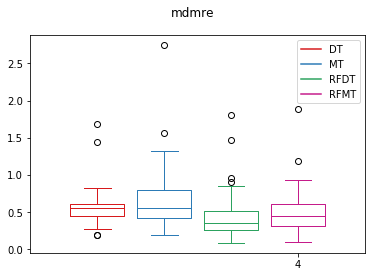

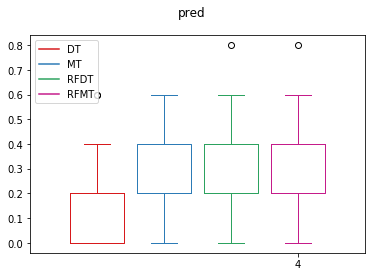

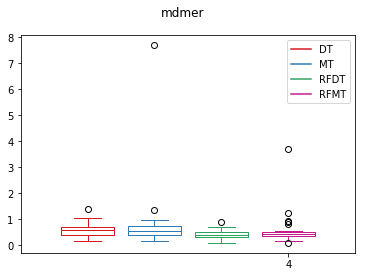

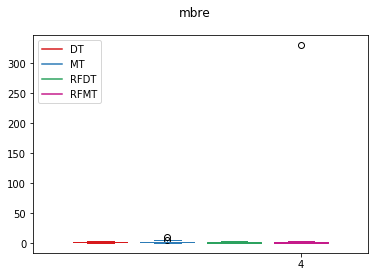

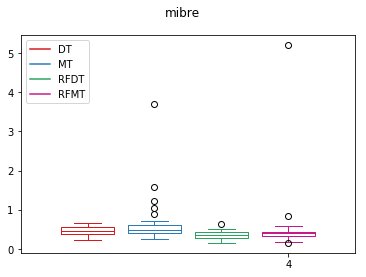

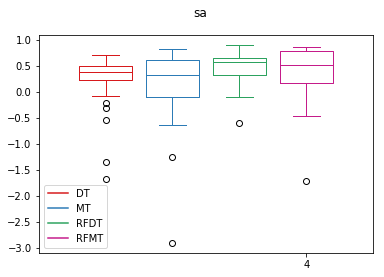

time: 4.42 s


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

ticks = ['mmre', 'mdmre', 'pred', 'mmer', 'mdmer', 'mae', 'mbre', 'mibre', 'sa']

for item in ticks:
    fig, ax = plt.subplots()
    fig.suptitle("{}".format(item))
    bpll = ax.boxplot(m_dt[item], positions=[1], widths=0.8)
    bplr = ax.boxplot(m_mt[item], positions=[2], widths=0.8)
    bprl = ax.boxplot(m_rfdt[item], positions=[3], widths=0.8)
    bprr = ax.boxplot(m_rfmt[item], positions=[4], widths=0.8)
    set_box_color(bpll, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bplr, '#2C7BB6')
    set_box_color(bprl, '#2CA25F')
    set_box_color(bprr, '#C51B8A')
    ax.plot([], c='#D7191C', label='DT')
    ax.plot([], c='#2C7BB6', label='MT')
    ax.plot([], c='#2CA25F', label='RFDT')
    ax.plot([], c='#C51B8A', label='RFMT')
    ax.legend()
    plt.xlim(0, 5)

plt.show()

## LaTeX-Tabelle

In [10]:
methods = ['dt', 'mt', 'rfdt', 'rfmt']
greater_is_better = [False, False, True, False, False, False, False, False, True]
ticks = ['mmre', 'mdmre', 'pred', 'mmer', 'mdmer', 'mae', 'mbre', 'mibre', 'sa']
for j, t in enumerate(ticks):
    values = []
    values.append(np.mean(m_dt[t]))
    values.append(np.mean(m_mt[t]))
    values.append(np.mean(m_rfdt[t]))
    values.append(np.mean(m_rfmt[t]))
    values_s = sorted(values, reverse = greater_is_better[j])
    rank = {}
    for i, method in enumerate(methods):
        c = values.index(values_s[i])
        rank[methods[c]] = i
        
    print("\t{}".format(t.upper()), end='', flush=True)
    for i, method in enumerate(methods):
        print(" & \cellcolor{{gr0{}}} {:.4f}".format(rank[method]+1, values[i]), end='', flush=True)
        
    print(" \\\\")

	MMRE & \cellcolor{gr03} 1.1883 & \cellcolor{gr04} 1.4971 & \cellcolor{gr01} 1.0107 & \cellcolor{gr02} 1.1211 \\
	MDMRE & \cellcolor{gr03} 0.5908 & \cellcolor{gr04} 0.7006 & \cellcolor{gr01} 0.4812 & \cellcolor{gr02} 0.5138 \\
	PRED & \cellcolor{gr04} 0.1800 & \cellcolor{gr03} 0.2533 & \cellcolor{gr01} 0.3600 & \cellcolor{gr02} 0.3333 \\
	MMER & \cellcolor{gr02} 0.8964 & \cellcolor{gr03} 1.2561 & \cellcolor{gr01} 0.5065 & \cellcolor{gr04} 11.7715 \\
	MDMER & \cellcolor{gr03} 0.5874 & \cellcolor{gr04} 0.8016 & \cellcolor{gr01} 0.3997 & \cellcolor{gr02} 0.5625 \\
	MAE & \cellcolor{gr03} 13.5722 & \cellcolor{gr04} 13.7653 & \cellcolor{gr02} 9.5530 & \cellcolor{gr01} 9.4272 \\
	MBRE & \cellcolor{gr02} 1.6279 & \cellcolor{gr03} 2.0874 & \cellcolor{gr01} 1.1551 & \cellcolor{gr04} 12.3368 \\
	MIBRE & \cellcolor{gr02} 0.4568 & \cellcolor{gr04} 0.6659 & \cellcolor{gr01} 0.3621 & \cellcolor{gr03} 0.5558 \\
	SA & \cellcolor{gr03} 0.2132 & \cellcolor{gr04} 0.1244 & \cellcolor{gr01} 0.4674 & \cellc